In [144]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
from scipy import io
import matplotlib.ticker as ticker
pyplot.style.use('seaborn')

In [145]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    #i: n_in, n_in-1, ..., 1，为滞后期数
    #分别代表t-n_in, ... ,t-1期
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #i: 0, 1, ..., n_out-1，为超前预测的期数
    #分别代表t，t+1， ... ,t+n_out-1期
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [146]:
def prepare_data(filepath, n_in, n_out=30, n_vars=4, train_proportion=0.8):
    #读取数据集
    df = read_csv(filepath, index_col=0)
    dataset = df.iloc[:, 1:]
    values = dataset.values
    #保证所有数据都是float32类型
    values = values.astype('float32')
    #变量归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    #将时间序列问题转化为监督学习问题
    reframed = series_to_supervised(scaled, n_in, n_out) #1807*500, dropna之后变少了, 500=n_vars*(n_in+n_out)=25*(10+10)
    #取出保留的变量
    contain_vars = []
    # [n_in x n_vars](10*25=250)个特征
    for i in range(1, n_in+1):
        contain_vars += [('var%d(t-%d)' % (j, i)) for j in range(1,n_vars+1)]
    # 再加上 [n_out]个预测的变量  
    data = reframed [ contain_vars + ['var1(t)'] + [('var1(t+%d)' % (j)) for j in range(1,n_out)]]
    #修改列名
    # col_names = ['Y', 'X1', 'X2', 'X3']
    col_names = ['Y'] + ['X'+str(i) for i in range(1, n_vars)]
    contain_vars = []
    for i in range(n_vars):
        contain_vars += [('%s(t-%d)' % (col_names[i], j)) for j in range(1,n_in+1)]  
    data.columns = contain_vars +  ['Y(t)'] + [('Y(t+%d)' % (j)) for j in range(1,n_out)]
    #分隔数据集，分为训练集和测试集 0.8的切分率
    values = data.values
    n_train = round(data.shape[0]*train_proportion)
    # 暂时使用-------------------------------------------------
    if train_proportion > 1:
        n_train = train_proportion
    train = values[:n_train, :]
    test = values[n_train:, :]
    #分割输入X和输出y
    train_X, train_y = train[:, :n_in*n_vars], train[:, n_in*n_vars:]
    test_X, test_y = test[:, :n_in*n_vars], test[:, n_in*n_vars:]
    #将输入X改造为LSTM的输入格式，即[samples,timesteps,features]
    train_X = train_X.reshape((train_X.shape[0], n_in, n_vars))
    test_X = test_X.reshape((test_X.shape[0], n_in, n_vars))
    return scaler, data, train_X, train_y, test_X, test_y, dataset

In [147]:
def fit_lstm(data_prepare, n_neurons=50, n_batch=72, n_epoch=100, loss='mae', optimizer='adam', repeats=1):
    train_X = data_prepare[2]
    train_y = data_prepare[3]
    test_X = data_prepare[4]
    test_y = data_prepare[5]
    model_list = []
    loss_list = []
    val_loss_list = []
    for i in range(repeats):
        print('training mode : ', i)
        #设计神经网络
        model = Sequential()
        model.add(LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(train_y.shape[1]))
        model.compile(loss=loss, optimizer=optimizer)
        #拟合神经网络
        history = model.fit(train_X, train_y, epochs=n_epoch, batch_size=n_batch, validation_data=(test_X, test_y), verbose=0, shuffle=False)
        #画出学习过程
        # p1 = pyplot.plot(history.history['loss'], color = 'blue', label='train')
        # p2 = pyplot.plot(history.history['val_loss'], color = 'red', label='test')
        loss_list.append(history.history['loss'])
        val_loss_list.append(history.history['val_loss'])
        #保存model
        model_list.append(model)
    train_loss = np.array(loss_list)
    val_loss = np.array(val_loss_list)
    train_mean = np.mean(train_loss, axis=0)
    train_std = np.std(train_loss, axis=0)
    val_mean = np.mean(val_loss, axis=0)
    val_std = np.std(val_loss, axis=0)
    x_list = range(len(loss_list[0]))

    pyplot.figure(figsize=[12,8])
    pyplot.plot(x_list, train_mean, color = 'blue', label='train')
    pyplot.fill_between(x_list, train_mean+train_std, train_mean-train_std, alpha=0.15,color='blue')
    pyplot.plot(x_list, val_mean, color = 'red', label='train')
    pyplot.fill_between(x_list, val_mean+val_std, val_mean-val_std, alpha=0.15,color='red')
    pyplot.legend(["train","test"])
    pyplot.show()
    return model_list

In [148]:
def lstm_predict(model, data_prepare):
    scaler = data_prepare[0]
    test_X = data_prepare[4]
    test_y = data_prepare[5]
    #做出预测
    yhat = model.predict(test_X)
    #将测试集上的预测值还原为原来的数据维度
    scale_new = MinMaxScaler()
    scale_new.min_, scale_new.scale_ = scaler.min_[0], scaler.scale_[0]
    inv_yhat = scale_new.inverse_transform(yhat)
    #将测试集上的实际值还原为原来的数据维度
    inv_y = scale_new.inverse_transform(test_y)
    return inv_yhat, inv_y

In [149]:
# 计算每一步预测的RMSE
def evaluate_forecasts(test, forecasts, n_out):
    rmse_dic = {}
    for i in range(n_out):
        actual = [float(row[i]) for row in test]
        predicted = [float(forecast[i]) for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        rmse_dic['t+' + str(i+1) + ' RMSE'] = rmse
    return rmse_dic

In [150]:
# #以原始数据为背景画出预测数据
# def plot_forecasts(series, forecasts):
#     #用蓝色画出原始数据集
#     pyplot.figure(figsize=[12, 8])
#     pyplot.plot(series.values, label = 'real', color='royalblue')
#     forecasts = forecasts.flatten()[:, np.newaxis]
#     np.insert(forecasts, 0, forecasts[0][0])
#     pyplot.plot(forecasts, label='forecast', color = 'orange')
#     pyplot.xlabel('Date')
#     pyplot.ylabel('loss')
#     pyplot.show()

In [151]:
#以原始数据为背景画出预测数据
def plot_forecasts(series, forecasts):
    forecasts = forecasts.flatten()[:, np.newaxis]
    np.insert(forecasts, 0, forecasts[0][0])
    #用蓝色画出原始数据集
    fig = pyplot.figure(figsize=[12, 8])
    ax = fig.add_subplot(111)
    ax.plot(series.values, label = 'real', color = 'royalblue')
    ax.plot(forecasts, label = 'forecast', color='orange')
    # 设置坐标轴格式
    def format_date(x, pos=None):
        x = x+1025
        if x < 0 or x > len(date_range):
            return ''
        return date_range[int(x)]
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
    pyplot.legend()
    pyplot.setp(pyplot.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    pyplot.ylabel('prices')
    pyplot.show()

In [152]:
# 日期
date_range = pd.read_csv('../data/gold_complete.csv', index_col=0)['Date'].values

training mode :  0
training mode :  1
training mode :  2
training mode :  3
training mode :  4


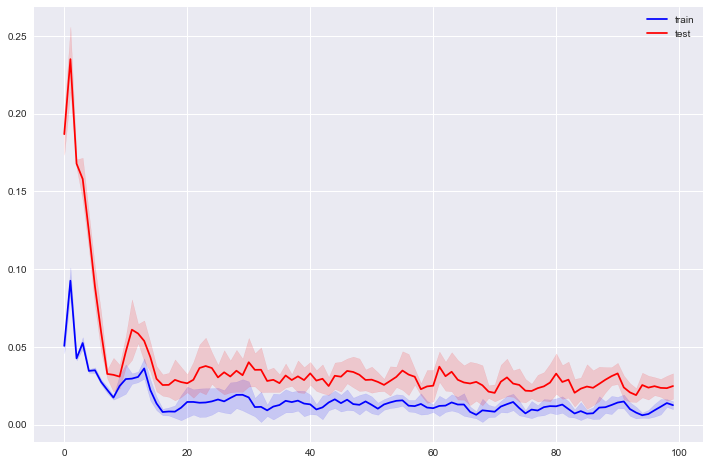

In [153]:
filepath = '../data/bitCoin_select.csv'
n_in = 1 # 滞后期数
n_out = 1 # 超前预测数
n_vars = 15 # 特征个数
n_neuron = 400 # lstm的隐藏层神经元个数
n_batch = 72 
n_epoch = 100
repeats = 5 # lstm重复训练的次数
inv_yhat_list = []
inv_y_list = []

data_prepare = prepare_data(filepath,n_in, n_out,n_vars=n_vars, train_proportion=999)
scaler, data, train_X, train_y, test_X, test_y, dataset = data_prepare
model_list = fit_lstm(data_prepare, n_neuron, n_batch, n_epoch,repeats=repeats)

for i in range(len(model_list)):
    model = model_list[i]
    inv_yhat = lstm_predict(model, data_prepare)[0] # n_test x n_out
    inv_y = lstm_predict(model, data_prepare)[1]
    inv_yhat_list.append(inv_yhat)
    inv_y_list.append(inv_y)

In [154]:
# 求出平均结果
inv_yhat_ave = np.zeros(inv_y.shape)
for i in range(repeats):
    inv_yhat_ave += inv_yhat_list[i]
inv_yhat_ave = inv_yhat_ave/repeats
# 模型评价
rmse_dic_list = []
for i in range(len(model_list)):
    inv_yhat = inv_yhat_list[i]
    inv_y = inv_y_list[i]
    rmse_dic = evaluate_forecasts(inv_y, inv_yhat, n_out)
    rmse_dic_list.append(rmse_dic)

rmse_dic_list.append(evaluate_forecasts(inv_y, inv_yhat_ave, n_out))

df_dic = {}
for i in range(len(rmse_dic_list) - 1):
    df_dic['第' + str(i+1) + '次'] = pd.Series(rmse_dic_list[i])
    
df_dic['平均'] = pd.Series(rmse_dic_list[i+1])
rmse_df = DataFrame(df_dic)
rmse_df

,第1次,第2次,第3次,第4次,第5次,平均
t+1 RMSE,2604.124479,1804.964333,1658.963075,2376.065635,4110.93073,1800.297902


###  按步平均预测错误率结果表

In [155]:
s = inv_yhat_ave[0].shape
erro_rate = np.zeros(s)
for i in range(len(inv_y)):
    erro_rate += inv_yhat_ave[i]/inv_y[i]-1

erro_rate_ave = erro_rate/len(inv_y)
err_df = DataFrame(pd.Series(erro_rate_ave))
err_df.columns = ['平均预测错误率']
err_df.index = ['超前%d步预测' % (i+1) for i in range(n_out)]
err_df

,平均预测错误率
超前1步预测,-0.021516


In [156]:
test_X.shape

(826, 1, 15)

In [157]:
inv_yhat_ave.shape

(826, 1)

##  可视化

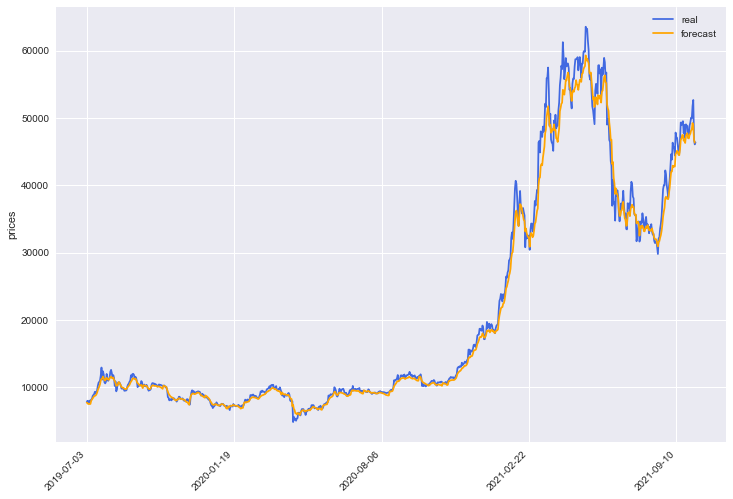

In [158]:
n_real = len(dataset)-len(test_X)-len(inv_yhat[0])
#多画一个
y_real = DataFrame(dataset['Value'][n_real:])
plot_forecasts(y_real, inv_yhat_ave)

###  导出结果

In [159]:
predict_y = pd.Series(inv_yhat_ave.flatten())
diff_y = (predict_y.diff(1)/predict_y)
diff_y[0]=diff_y[1]
diff_other_model = pd.read_csv('../data/predict/r_bitCoin_forecast1001to1825.csv', index_col=0)
diff_y = pd.DataFrame(diff_y, columns=['LSTM'])
diff_y.index = diff_other_model.index
diff_bitCoin = pd.concat([diff_y, diff_other_model], axis=1)

In [160]:
# diff_bitCoin.to_csv('../data/predict/bitCoin_1000to1825_all_model.csv')

In [161]:
np.mean(diff_y.values)

0.0019587915706035953

保存价格

In [162]:
# df_bitcoin = pd.DataFrame(predict_y, columns=['LSTM'])
# df_bitcoin.to_csv('../data/predict/bitCoin_price_predict.csv')
# io.savemat('../code/matlab/bitCoin_preice.mat', {'array' : predict_y.values})

### 预测全部时间的数据

In [163]:
train_all = data.iloc[:,:-1].values
train_all = train_all.reshape((train_all.shape[0], n_in, n_vars))
train_all.shape

(1825, 1, 15)

In [164]:
y_hat_all = model.predict(train_all)
scale_new = MinMaxScaler()
scale_new.min_, scale_new.scale_ = scaler.min_[0], scaler.scale_[0]
inv_yhat_all = scale_new.inverse_transform(y_hat_all)

In [165]:
predict_y = pd.Series(inv_yhat_all.flatten())
diff_y = (predict_y.diff(1)/predict_y)
diff_y[0]=diff_y[1]

In [166]:
diff_y

0       0.033854
1       0.033854
2      -0.011511
3       0.008458
4      -0.009617
          ...   
1820    0.003826
1821    0.018858
1822   -0.021639
1823   -0.042262
1824   -0.006919
Length: 1825, dtype: float32

In [167]:
io.savemat('../code/matlab/bitCoin_predict_all.mat', {'bitCoin' :diff_y.values })

In [168]:
# %目标函数 需要改成min的形式

# function f=fun1(w)
# %示例
# w=rand(3, 1);
# load('gold_predict_all.mat');
# load('bitCoin_predict_all.mat');
# r_gold = gold';
# r_bitcoin = bitCoin';
# r_gold = r_gold(1000:1825);
# r_bitcoin = r_bitcoin(1000:1825);

# zero=rand([length(r_gold),1])*0.0001; % 826 x 1
# covlist = [zero r_gold r_bitcoin]; %826 x 3

# mu=[0;mean(r_gold);mean(r_bitcoin)];%3*1 均值向量
# alpha_gold = 0.01;%黄金的手续
# alpha_b = 0.02;
# price_gold=1788.80209960938;%黄金的价格
# price_b = 43730.0796875000;
# gamma =1;%风险厌恶系数
# tc = [0; - alpha_gold * price_gold; - alpha_b * price_b;];%3*1
# sigma = cov(covlist);    
     
# maxf=mu'*(w + tc) - gamma/2 * (w + tc)' * sigma * (w + tc);
# f = -maxf;%min的形式

In [169]:

# global i
# res = zeros(800, 2);
# for i=1:800
#     [x,y]=fmincon('fun1',rand(3,1),[],[],[1 1 1],1,[0 0 0],[1 1 1]);
#     res(i, 1) = x;
#     res(i, 2) = y;
# end